# Exercise 4.4.2  

**Medium**: Simulate a MA(q) process and make forecasts
* Recreate the previous exercise but simulate a moving average process of your choice. Try simulating a third-order or fourth-order moving average process. Here, I would recommend generating 10,000 samples. Be especially attentive to the ACF and see if your coefficients become non-significant after lag q.

In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42) #A
ma3 = np.array([1, 0.9, 0.5, 0.3])
ar2 = np.array([1, 0, 0, 0])
MA3_process = ArmaProcess(ar2, ma3).generate_sample(nsample=10000)

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import sys
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '/home/oliver/Documents/Code/myrepos/TimeSeriesForecastingInPython/MyWork/../../My-Code/timetools.py'>

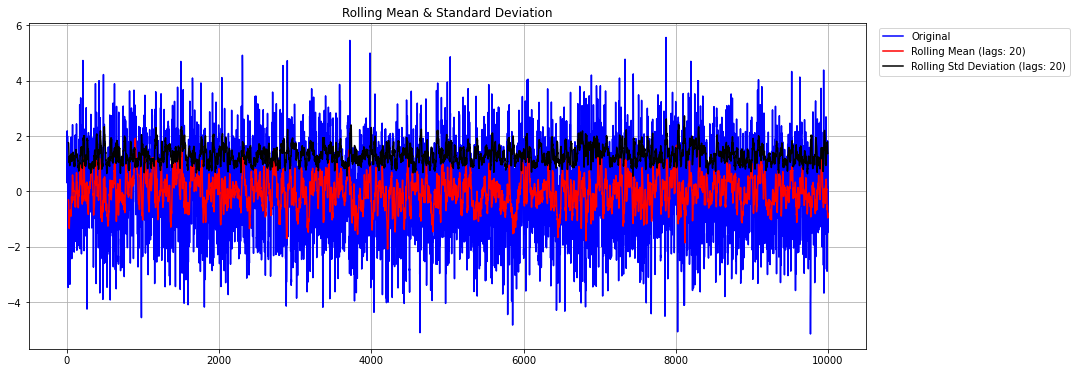

In [3]:
# Plot your simulated moving average.
tt.plot_for_stationary(pd.Series(MA3_process))

In [4]:
# Run the ADF test and check if the process is stationary.
tt.adf(MA3_process)

Test Statistic                  -25.831125
p-value                           0.000000
#Lags Used                       12.000000
Number of Observations Used    9987.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64

The time series is stationary.


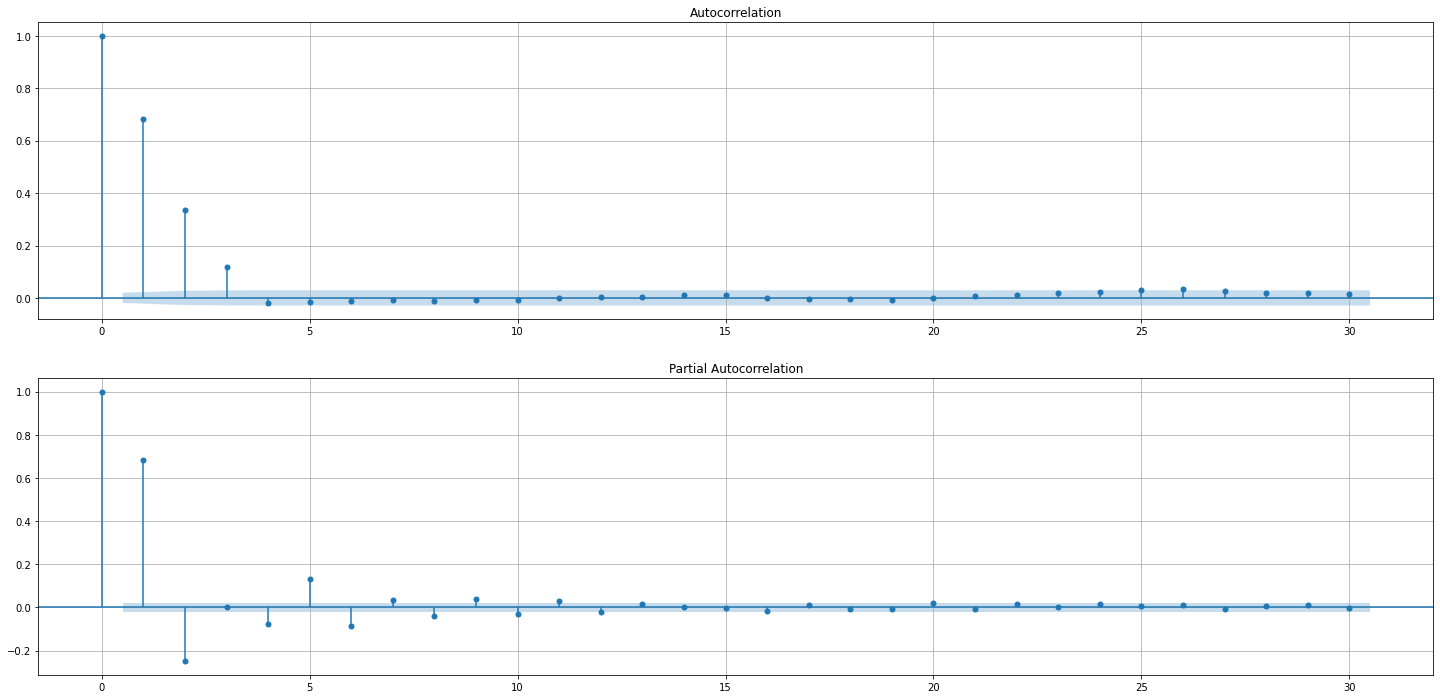

In [5]:
# Plot the ACF and see if there are or are not significant coefficients after lag 2.
tt.plot_acf_pcf(MA3_process, num_lag=30)

In [6]:
df = pd.DataFrame(MA3_process, columns=['value'])
df.tail()

,value
9995,1.825228
9996,-0.679837
9997,-1.495012
9998,-0.747861
9999,0.138416


In [7]:
# Separate your simulated series into a training and test set. Take the first 800 timesteps for the training set 
# and assign the rest to the test set.
train, test = df[:int(0.8*(df.shape[0]))], df[int(0.8*(df.shape[0])):]
print('length of train dataset: {}'.format(len(train)))
print('length of test dataset:  {}'.format(len(test)))

length of train dataset: 8000
length of test dataset:  2000


In [8]:
# Make forecasts over the test set. Use the mean, last value, and a MA(3) model. Make sure to repeatedly forecast 3 timesteps at 
# time using the recursive_forecast function as defined.
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    '''
    pred_df   = test.copy()
    TRAIN_LEN = len(train)
    HORIZON   = len(test)
    WINDOW    = 3          ->      predicts next three time steps
    method    =            ->      mean, last, or moving average
    '''
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [149]:
# omd

i = 10000
window = 1
train_len = 8000
total_len = 8010     #10000

pred_MA = []       
for i in range(train_len, total_len, window):
    model = SARIMAX(df[:i], order=(0,0,3))
    res = model.fit(disp=False)
    predictions = res.get_prediction(0, i + window - 1)
    oos_pred = predictions.predicted_mean.iloc[-window:]
    pred_MA.extend(oos_pred)

pred_MA

[2.3824314810677185,
 1.5123462559286736,
 0.19576756195602335,
 -0.4241568503774419,
 0.38264925966283453,
 1.4313765855398173,
 1.3650706243402837,
 0.7680308426626784,
 1.5482482500379442,
 0.48453815260874433]

In [9]:
pred_df = pd.DataFrame(test, columns=['value'])

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')   # omd: the thing is that actual data points for forecast horizon won't be available going forward.  hence this is not a feasible solution.
pred_MA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head(8)

,value,pred_mean,pred_last_value,pred_MA
8000,2.412894,-0.009913,3.245935,2.382431
8001,1.001390,-0.009610,2.412894,1.512346
8002,-0.018840,-0.009484,1.001390,0.195768
8003,0.297862,-0.009485,-0.018840,-0.424157
8004,1.683833,-0.009447,0.297862,0.382649
8005,2.026212,-0.009235,1.683833,1.431377
8006,1.468510,-0.008981,2.026212,1.365071
8007,2.258163,-0.008797,1.468510,0.768031


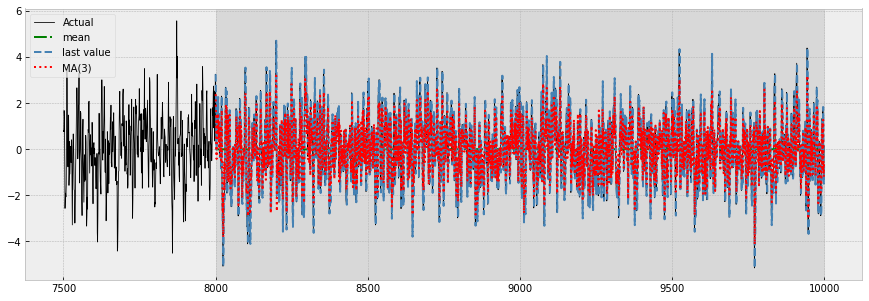

In [10]:
# Plot your forecasts
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df[7500:], color='black', lw='0.8', label='Actual')
ax.axvspan(xmin=8000, xmax=10000, color='#808080', alpha=0.2)
ax.plot(pred_df['pred_mean'], color='green', ls='-.', label='mean')
ax.plot(pred_df['pred_last_value'], color='steelblue', ls='--', label='last value')
ax.plot(pred_df['pred_MA'], color='red', ls='dotted', label='MA(3)')
plt.legend()
plt.show(); plt.style.use('default')

In [12]:
# Measure the MSE and identify your champion model

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['value'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['value'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['value'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.0421947503956743 1.3151881389199143 0.9779070133620148


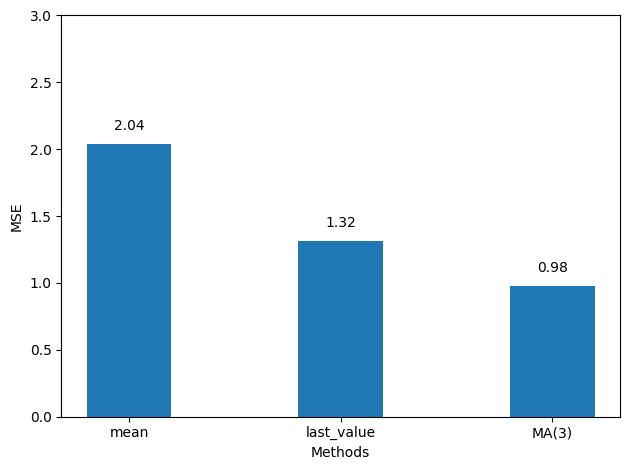

In [13]:
# Plot your MSEs in a bar plot
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(3)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH04_F09_peixeiro.png', dpi=300)